# Imports

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage.io import imread
from model.SEResNet import SEResNet
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load Trained Model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SEResNet()
model.load_state_dict(torch.load("../data/model/best_model.pth", map_location=device))
model.to(device)
model.eval()

C:\Users\felix\AppData\Local\Temp\ipykernel_780\1861633252.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../data/model/best_model.pth

SEResNet(
  (initial_conv): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (encoder): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(12, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (norm1): GroupNorm(4, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (norm2): GroupNorm(4, 64, eps=1e-05, affine=True)
      (se): SEBlock(
        (se): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
          (2): SiLU()
          (3): Conv2d(8, 64, kernel_size=(1, 1), stride=(1, 1))
          (4): Sigmoid()
        )
      )
      (activation): SiLU()
      (residual_conv): Conv2d(12, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=refl

In [3]:
# Load trained statistics
with open('../data/model/train_stats.dat', 'r') as f:
    stats = json.load(f)
    stats['band_means'] = np.array(stats['band_means'])
    stats['band_stds'] = np.array(stats['band_stds'])

def predict(model, img, label, stats=stats, device=device):
    img = (img - stats['band_means']) / stats['band_stds']
    mask = (label != 255).astype(np.float32)  # 1 where valid, 0 where missing
    label = np.where(mask, (label - stats['label_mean']) / stats['label_std'], 0)
    img = torch.tensor(img, dtype=torch.float32).to(device)
    label = torch.tensor(label, dtype=torch.float32).to(device)
    img = img.unsqueeze(0).permute(0,3,1,2)
    print(img.shape)
    return (model(img).cpu().squeeze().detach().numpy() * stats['label_std'] + stats['label_mean'])

# Inference On One Image

In [4]:
sample_img = imread("../data/sample/sample_image.tif")
sample_label = imread("../data/sample/sample_label.tif")

predicted_label = predict(model, sample_img, sample_label)

torch.Size([1, 12, 32, 32])


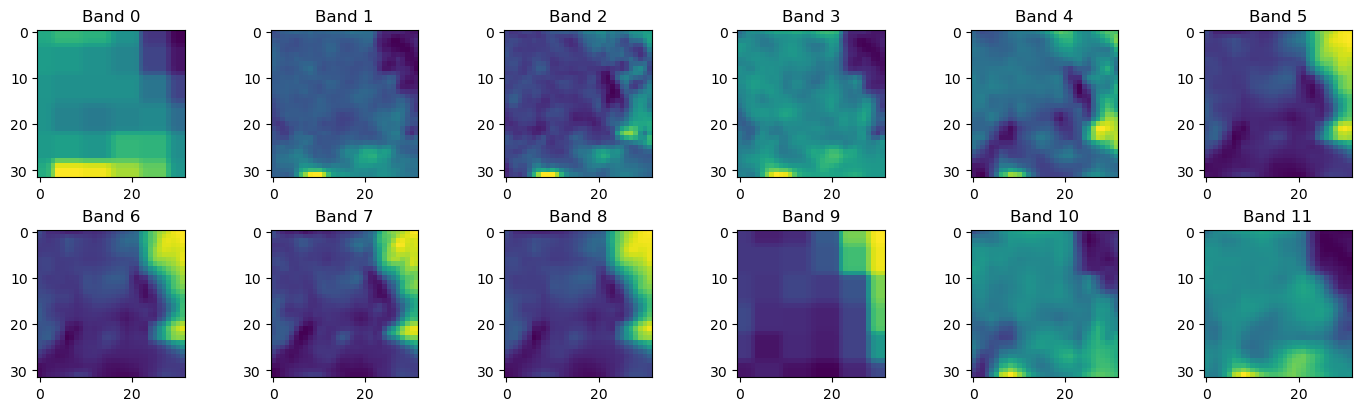

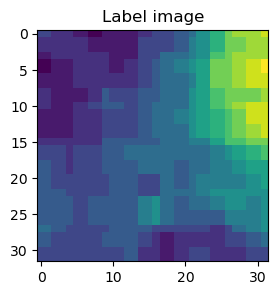

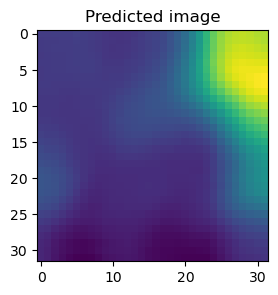

In [5]:
# Plot all 12 bands
f, axs = plt.subplots(2, 6, figsize=(14, 4), constrained_layout=True)
axs = axs.flatten()

for i in range(12):
    axs[i].imshow(sample_img[:, :, i])
    axs[i].set_title(f"Band {i}")

# Plot label image
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(sample_label)
ax.set_title("Label image")

# Plot predicted image
f, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(predicted_label)
ax.set_title("Predicted image")

plt.show()


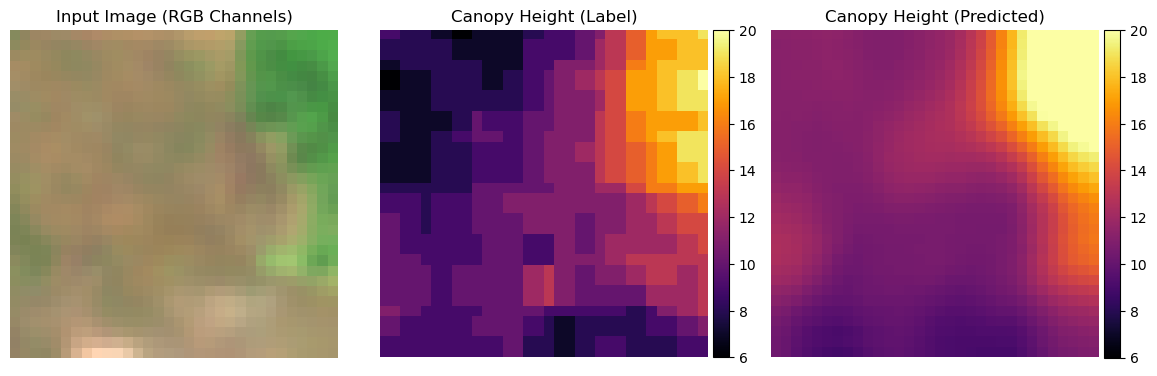

In [6]:
# Define figure layout
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 4, width_ratios=[1.881, 2, 2, 0.1]) 

# Plot RGB Sentinel-2 Image (Bands 4,3,2 -> RGB)
ax_rgb = fig.add_subplot(gs[0])
rgb_image = np.stack([sample_img[:, :, 3],  # Red (Band 4)
                      sample_img[:, :, 2],  # Green (Band 3)
                      sample_img[:, :, 1]], axis=-1)  # Blue (Band 2)
rgb_image = np.clip(rgb_image / np.max(rgb_image), 0, 1)

ax_rgb.imshow(rgb_image)
ax_rgb.set_title("Input Image (RGB Channels)")
ax_rgb.axis("off")

vmin, vmax = sample_label.min(), sample_label.max()

def add_colorbar(ax, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)

# Plot label image
ax_label = fig.add_subplot(gs[1])
im_label = ax_label.imshow(sample_label, cmap="inferno", vmin=vmin, vmax=vmax)
ax_label.set_title("Canopy Height (Label)")
ax_label.axis("off")
add_colorbar(ax_label, im_label)

# Plot predicted image
ax_pred = fig.add_subplot(gs[2])
im_pred = ax_pred.imshow(predicted_label, cmap="inferno", vmin=vmin, vmax=vmax)
ax_pred.set_title("Canopy Height (Predicted)")
ax_pred.axis("off")
add_colorbar(ax_pred, im_pred)  

plt.tight_layout()
plt.savefig("../out/sample_inference.pdf", format="pdf", bbox_inches="tight")
plt.show()
